## Settings

In [19]:
import warnings
import os
import sys
from sys import platform
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
BASE_PATH = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1]) + '/'
sys.path.append(BASE_PATH+'\src' if platform == 'win32' else BASE_PATH+'/src')
from config.global_config import get_global_config
from utils import get_ds_statistics, get_model_type

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, accuracy_score, precision_score, recall_score, f1_score

In [2]:
_config = get_global_config()
DATA_PATH = os.path.join(BASE_PATH, _config.get('DATASET_PATH'))
RESULTS_PATH = os.path.join(BASE_PATH, _config.get('RESULT_PATH_SHARED'))
DATASET_FILE = os.path.join(BASE_PATH, _config.get('DATASET_FILE'))
if platform == 'win32':
	DATA_PATH = DATA_PATH.replace('/', '\\')
	RESULTS_PATH = RESULTS_PATH.replace('/', '\\')
	DATASET_FILE = DATASET_FILE.replace('/', '\\')
EMISSIONS_FILE = 'emissions.csv'
METRICS_FILE = 'metrics.csv'
PARAMS_FILE = 'params.csv'

In [3]:
data = pd.DataFrame({
	# Related to dataset
    'n_users': [],
    'n_items': [],
    'n_inter': [],
    'sparsity': [],

    # Related to KG dataset
	'kg_entities': [],
	'kg_relations': [],
	'kg_triples': [],
	'kg_items': [],

	# Related to hardware
    'cpu_cores': [],
    'ram_size': [],
    'is_gpu': [],

	# Related to model
	'model_name': [],
    'model_type': [],

	# Label
	'emissions': []
})

## Features extraction

In [4]:
experiments = []
for d in next(os.walk(RESULTS_PATH))[1]:
	for m in next(os.walk(RESULTS_PATH + d))[1]:
		experiments.append(os.path.join(d, m))
experiments = sorted(experiments)

In [5]:
for i, v in enumerate(experiments):
	e = pd.read_csv(os.path.join(RESULTS_PATH, v, EMISSIONS_FILE))
	dataset = v.split("/")[0]
	model = v.split("/")[1]
	stats = get_ds_statistics(os.path.join(DATA_PATH, dataset))
	for _, row in e.iterrows():
		data.loc[len(data)] = [
			stats['n_users'],
			stats['n_items'],
			stats['n_inter'],
			stats['sparsity'],
			stats['kg_entities'],
			stats['kg_relations'],
			stats['kg_triples'],
			stats['kg_items'],
			row['cpu_count'],
			row['ram_total_size'],
			row['gpu_count'] if row['gpu_count'] == 1. else .0,
			model,
			get_model_type(model),
			row['emissions'],
		]

In [6]:
data.sample(n=5)

,n_users,n_items,n_inter,sparsity,kg_entities,kg_relations,kg_triples,kg_items,cpu_cores,ram_size,is_gpu,model_name,model_type,emissions
144,6040,3706,1000209,0.955316,79347,49,385923,3655,4,16.0,0.0,MultiDAE,general,1.107043e-03
78,23679,4414,1048575,0.989968,0,0,0,0,12,64.0,1.0,MultiVAE,general,1.265962e-04
28,22155,54458,1465871,0.998785,26315,16,96476,11446,12,64.0,1.0,MKR,knowledge,4.965904e-03
106,6040,3706,1000209,0.955316,79347,49,385923,3655,12,64.0,1.0,CFKG,knowledge,9.617732e-05
157,6040,3706,1000209,0.955316,79347,49,385923,3655,12,64.0,1.0,Pop,general,5.986495e-07


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173 entries, 0 to 172
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   n_users       173 non-null    int64  
 1   n_items       173 non-null    int64  
 2   n_inter       173 non-null    int64  
 3   sparsity      173 non-null    float64
 4   kg_entities   173 non-null    int64  
 5   kg_relations  173 non-null    int64  
 6   kg_triples    173 non-null    int64  
 7   kg_items      173 non-null    int64  
 8   cpu_cores     173 non-null    int64  
 9   ram_size      173 non-null    float64
 10  is_gpu        173 non-null    float64
 11  model_name    173 non-null    object 
 12  model_type    173 non-null    object 
 13  emissions     173 non-null    float64
dtypes: float64(4), int64(8), object(2)
memory usage: 20.3+ KB


In [8]:
# UNCOMMENT TO SAVE CSV DATASET

# if not os.path.isfile(DATASET_FILE):
# 	os.unlink(DATASET_FILE)
# data.to_csv(DATASET_FILE, index=False, encoding='utf-8')

## Preprocessing

In [9]:
data = pd.read_csv(DATASET_FILE, encoding='utf-8')

In [10]:
# Null values check
data.isnull().any()

n_users         False
n_items         False
n_inter         False
sparsity        False
kg_entities     False
kg_relations    False
kg_triples      False
kg_items        False
cpu_cores       False
ram_size        False
is_gpu          False
model_name      False
model_type      False
emissions       False
dtype: bool

In [11]:
# Turn categorical features into numerical
data.loc[data['model_type'] == 'general', 'model_type'] = 0
data.loc[data['model_type'] == 'knowledge', 'model_type'] = 1
mymap = sorted(list(set(data['model_name'])))
for _, v in enumerate(mymap):
	data.loc[data['model_name'] == v, 'model_name'] = mymap.index(v)

In [12]:
# Turn continuous output values into discrete values
interval = (data['emissions'].max() - data['emissions'].min()) / 3
low_bound = data['emissions'].min() + interval
high_bound = data['emissions'].max() - interval

data_class = data.copy()
data_class.loc[data_class['emissions'] >= high_bound, 'emissions'] = 2
data_class.loc[(data_class['emissions'] > low_bound) & (data_class['emissions'] < high_bound), 'emissions'] = 1
data_class.loc[data_class['emissions'] <= low_bound, 'emissions'] = 0

In [13]:
data_class.emissions.value_counts()

emissions
0.0    166
2.0      4
1.0      3
Name: count, dtype: int64

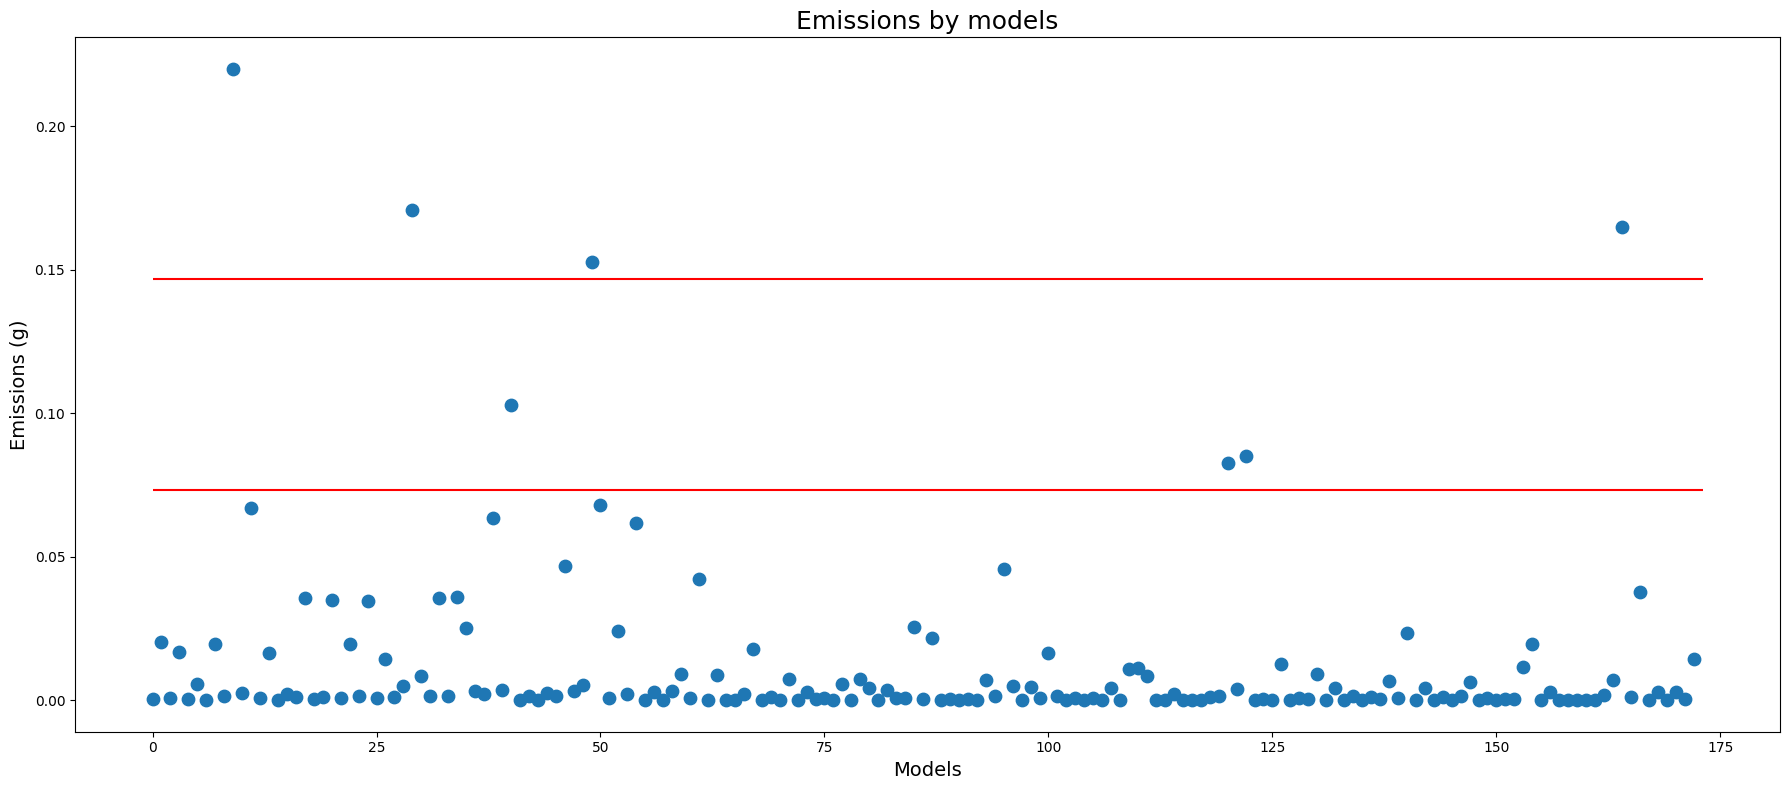

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(18, 8))
axs.scatter(range(len(data['emissions'])), data['emissions'], s=80)
axs.hlines(low_bound, 0, len(data['emissions']), colors='r')
axs.hlines(high_bound, 0, len(data['emissions']), colors='r')
axs.set_title('Emissions by models', fontsize=18)
axs.set_xlabel('Models', fontsize=14)
axs.set_ylabel('Emissions (g)', fontsize=14)
fig.tight_layout()
plt.show()

## Models definition

In [36]:
X = data.loc[:, data.columns != 'emissions']
y = data[['emissions']]
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype('float64'),
    y.values.astype('float64'),
    train_size = .7,
    test_size = .3,
    random_state = 2,
    shuffle = True
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

In [37]:
print(''.join(['> ' for i in range(35)]))
print(f'\n{"REGRESSOR":<20}{"MAE":>8}{"RMSE":>18}{"MSLE":>18}\n')
print(''.join(['> ' for i in range(35)]))

model = SVR()
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"SVR":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

model = DecisionTreeRegressor(max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"DECISION TREE":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"RANDOM FOREST":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

model = AdaBoostRegressor(n_estimators=500, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
mae = mean_absolute_error(pred, y_test)
rmse = mean_squared_error(pred, y_test)
msle = mean_squared_log_error(pred, y_test)
print(f'\n{"ADABOOST":<20}{mae:>8.7f}{rmse:>18.7f}{msle:>18.7f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

REGRESSOR                MAE              RMSE              MSLE

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

SVR                 0.0918887         0.0086944         0.0078474

DECISION TREE       0.0137811         0.0013210         0.0011466

RANDOM FOREST       0.0144916         0.0012280         0.0010648

ADABOOST            0.0173335         0.0011111         0.0009617


In [38]:
X = data_class.loc[:, data_class.columns != 'emissions']
y = data_class[['emissions']]
X_train, X_test, y_train, y_test = train_test_split(
    X.values.astype('float64'),
    y.values.astype('float64'),
    train_size = .7,
    test_size = .3,
    random_state = 2,
    shuffle = True,
	stratify=y
)
y_train = y_train.reshape(len(y_train),)
y_test = y_test.reshape(len(y_test),)

In [39]:
print(''.join(['> ' for i in range(42)]))
print(f'\n{"CLASSIFIER":<20}{"ACCURACY":>8}{"PRECISION":>18}{"RECALL":>18}{"F1_SCORE":>18}\n')
print(''.join(['> ' for i in range(42)]))
warnings.filterwarnings('ignore')
model = SVC()
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro', labels=np.unique(pred))
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"SVR":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

model = DecisionTreeClassifier(max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"DECISION TREE":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

model = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"RANDOM FOREST":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

model = AdaBoostClassifier(n_estimators=500, random_state=3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc = accuracy_score(pred, y_test)
prec = precision_score(pred, y_test, average='macro')
rec = recall_score(pred, y_test, average='macro')
f1 = f1_score(pred, y_test, average='macro')
print(f'\n{"ADABOOST":<20}{acc:>8.2f}{prec:>18.2f}{rec:>18.2f}{f1:>18.2f}')

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

CLASSIFIER          ACCURACY         PRECISION            RECALL          F1_SCORE

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

SVR                     0.96              0.33              0.96              0.33

DECISION TREE           0.94              0.33              0.32              0.32

RANDOM FOREST           0.94              0.33              0.32              0.32

ADABOOST                0.96              0.33              0.32              0.33
